<small><font color=gray>Автор соревнования: <a href="https://www.hse.ru/org/persons/863761973/" target="_blank">Копылов Иван</a> ©2025</font></small><hr style="margin:0;background-color:silver">

**<font size=6>ХАКАТОН
МТС Х Л2Ш Х ВОСХОД</font>**

## Вычислительные ресурсы для решения задачи соревнования

Решение данной задачи скорее всего потребует использование вычислений на видеокарте (GPU, графическом или тензорном процессоре). Для этого вы можете использовать любые имеющиеся у вас ресурсы (ваш ноутбук, сервер друга). Тем не менее, мы рекомендуем вам использовать Google Colab, который предоставляет достаточные ресурсы для решения задачи соревнования. Выполните следующую команду:

In [1]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15095 MiB, 0 MiB


Видно, что сейчас используется видеокарта NVIDIA Tesla T4 с 16 ГБ видеопамяти. Смотрите [подробнее](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) о запросе информации о видеокартах NVIDIA.

Обратите внимание, что выделенные ресурсы в бесплатной версии Google Colab [имеют ограничения](https://research.google.com/colaboratory/faq.html#resource-limits). Это означает, что при интенсивном обращении к видеокарте (более нескольких часов в день), вы можете увидеть сообщение "You cannot currently connect to a GPU due to usage limits in Colab." и потерять доступ к видеокарте на часы или даже на дни (при этом доступ к центральному процессору, предположительно, сохранится).

# Необходимый код
**Не удаляйте этот код.**

In [ ]:
!pip install facenet_pytorch # если не импортировано

In [2]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os # загрузка основных библиотек для работы с данными

# Загрузка библиотеки pytorch и необходимых модулей
import torch, torchvision
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torch import nn
from torch.nn import Sequential, Flatten, Linear, LazyLinear, Dropout, AdaptiveAvgPool2d, MaxPool2d, Conv2d, AvgPool2d

# from torchvision.models import resnet50, mobilenet_v2
from torchvision.datasets import ImageFolder
import torchvision.transforms as v2

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # округляет значения до 2 десятичных знаков

RunTimeLimit, t0 = 300, time.time() # ограничение по времени работы вашей модели и время начала работы

class Timer():
  def __init__(self, lim:'RunTimeLimit'=300): self.t0, self.lim, _ = time.time(), lim, print(f'отсчет ⏳ начался. У вашей модели есть только {lim} секунд. Удачи!')
  def ShowTime(self):
    msg = f'Время выполнения {time.time()-self.t0:.0f} с'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} секунд на предельное время выполнения!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'train/', 'test/'

CPU times: user 3.44 s, sys: 542 ms, total: 3.98 s
Wall time: 5.59 s


In [3]:
# pip freeze | grep torch*

### Примеры изображений лиц из директории `train/female`

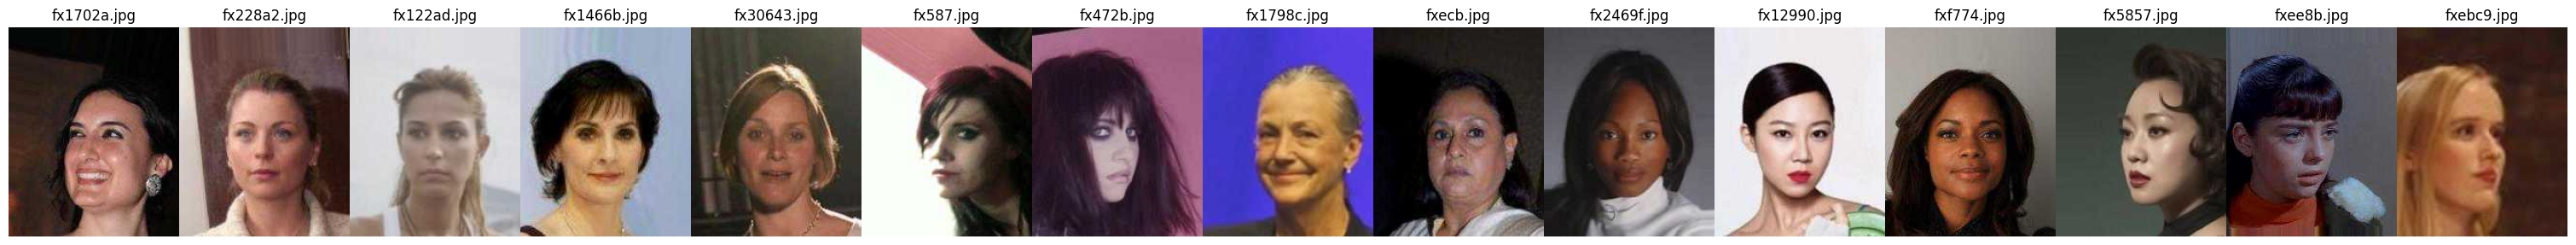

In [4]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'female/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'female/'+f);
  _ = ax.set_title(f'{f}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

### Примеры изображений лиц из директории `train/male`

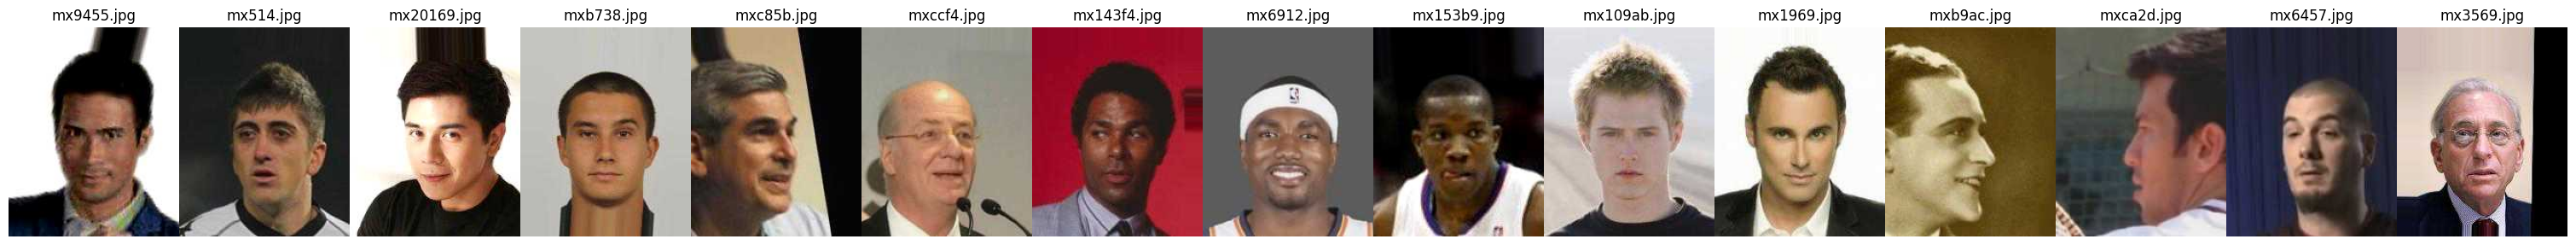

In [5]:
n, fig = 15, plt.figure(figsize=(30,10));
for i, f in enumerate(np.random.RandomState(0).choice(os.listdir(tDIR+'male/'), n)):
  ax = plt.subplot(1, n, i + 1)
  img = plt.imread(tDIR+'male/'+f);
  _ = ax.set_title(f'{f}');
  _ = plt.axis('off');   _ = plt.tight_layout(pad=0);   _ = plt.imshow(img);

In [6]:
tmr = Timer()

отсчет ⏳ начался. У вашей модели есть только 300 секунд. Удачи!


<hr color=green size=40>

<font size=5>⏳</font> <strong><font color=green size=5>Ваш код, идеи, ссылки и документацию - все записываете здесь...</font></strong>

<font color=green> **Раздел для участников соревнования** (между символами ⏳): добавьте сюда свой код и документацию.


In [7]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Используется случайное число {seed}")

set_seed(0xb00b5)

Используется случайное число 0


In [8]:
def getDevice():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

DEVICE = getDevice()
print("Используем", DEVICE)

Используем cuda


In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 160
CLASSIFIER_EPOCHS = 100
CLASSIFIER_LR = 1e-3

In [10]:
from facenet_pytorch import InceptionResnetV1

train_transform = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=3),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [11]:
train_dataset = ImageFolder('train/', transform=train_transform)
test_dataset = ImageFolder('test/', transform=test_transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [12]:
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE);

def extract_embeddings(model, dataloader, desc="Extracting"):
    embeddings_list = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.to(DEVICE)

            # --- NEW CODE START ---
            # 1. Forward pass original
            emb_orig = model(images)
            # 2. Forward pass flipped
            emb_flip = model(torch.flip(images, [3])) # Flip width dimension
            # 3. Average them
            emb = (emb_orig + emb_flip) / 2
            # --- NEW CODE END ---

            embeddings_list.append(emb.cpu())
            labels_list.append(labels)

            if batch_idx % 20 == 0:
                print(f"{desc}: batch {batch_idx}/{len(dataloader)}")

    embeddings = torch.cat(embeddings_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return embeddings, labels

train_embeddings, train_labels = extract_embeddings(facenet, train_loader, "Train")
val_embeddings, val_labels = extract_embeddings(facenet, val_loader, "Validation")
test_embeddings, _ = extract_embeddings(facenet, test_loader, "Test")

  0%|          | 0.00/107M [00:00<?, ?B/s]

Train: batch 0/125
Train: batch 20/125
Train: batch 40/125
Train: batch 60/125
Train: batch 80/125
Train: batch 100/125
Train: batch 120/125
Validation: batch 0/32
Validation: batch 20/32
Test: batch 0/157
Test: batch 20/157
Test: batch 40/157
Test: batch 60/157
Test: batch 80/157
Test: batch 100/157
Test: batch 120/157
Test: batch 140/157


In [13]:
%%capture

class EmbeddingClassifier(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.classifier(x)

classifier = EmbeddingClassifier(input_dim=512, hidden_dim=256, dropout=0.3).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=CLASSIFIER_LR, weight_decay=0.01)

In [14]:
train_emb_ds = torch.utils.data.TensorDataset(train_embeddings, train_labels)
val_emb_ds = torch.utils.data.TensorDataset(val_embeddings, val_labels)

target_labels = train_labels.long()
class_counts = torch.bincount(target_labels)
class_weights = 1. / class_counts.float()
sample_weights = class_weights[target_labels]

from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_emb_loader = DataLoader(train_emb_ds, batch_size=128, sampler=sampler)
val_emb_loader = DataLoader(val_emb_ds, batch_size=128, shuffle=False)

best_val_acc = 0
best_epoch = 0
best_model_state = None
history = {'train_loss': [], 'val_acc': []}

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2
)
"""
    max_lr=CLASSIFIER_LR * 10,
    epochs=CLASSIFIER_EPOCHS,
    steps_per_epoch=len(train_emb_loader),
    pct_start=0.3,
    anneal_strategy='cos',
    final_div_factor=100
    """

"\n    max_lr=CLASSIFIER_LR * 10,\n    epochs=CLASSIFIER_EPOCHS, \n    steps_per_epoch=len(train_emb_loader),\n    pct_start=0.3,\n    anneal_strategy='cos',\n    final_div_factor=100\n    "

In [15]:
for epoch in range(CLASSIFIER_EPOCHS):
    # training
    _ = classifier.train()
    train_loss = 0
    for embeddings, labels in train_emb_loader:
        embeddings, labels = embeddings.to(DEVICE), labels.to(DEVICE).float()

        optimizer.zero_grad()
        outputs = classifier(embeddings).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_emb_loader)

    # validation
    _ = classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_emb_loader:
            embeddings, labels = embeddings.to(DEVICE), labels.to(DEVICE)
            outputs = classifier(embeddings).squeeze()
            predictions = (torch.sigmoid(outputs) > 0.5).long()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    # scheduler.step(val_acc)

    history['train_loss'].append(avg_train_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        best_model_state = classifier.state_dict().copy()

    if epoch % 10 == 0 or epoch == CLASSIFIER_EPOCHS - 1:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Эпоха {epoch:3d}/{CLASSIFIER_EPOCHS} | loss: {avg_train_loss:.4f} | acc: {val_acc:.4f} | lr: {current_lr:.6f} | best: {best_val_acc:.4f}")

print(f"Наибольшая точность: {best_val_acc:.4f} (Эпоха {best_epoch})")

classifier.load_state_dict(best_model_state)
torch.save(best_model_state, 'best.pth')

_ = None

Эпоха   0/100 | loss: 0.2824 | acc: 0.9250 | lr: 0.000994 | best: 0.9250
Эпоха  10/100 | loss: 0.0547 | acc: 0.9870 | lr: 0.000958 | best: 0.9870
Эпоха  20/100 | loss: 0.0301 | acc: 0.9830 | lr: 0.000989 | best: 0.9870
Эпоха  30/100 | loss: 0.0175 | acc: 0.9870 | lr: 0.000398 | best: 0.9880
Эпоха  40/100 | loss: 0.0125 | acc: 0.9830 | lr: 0.000997 | best: 0.9880
Эпоха  50/100 | loss: 0.0102 | acc: 0.9830 | lr: 0.000815 | best: 0.9880
Эпоха  60/100 | loss: 0.0082 | acc: 0.9840 | lr: 0.000449 | best: 0.9880
Эпоха  70/100 | loss: 0.0045 | acc: 0.9850 | lr: 0.000112 | best: 0.9880
Эпоха  80/100 | loss: 0.0085 | acc: 0.9860 | lr: 0.000999 | best: 0.9880
Эпоха  90/100 | loss: 0.0101 | acc: 0.9830 | lr: 0.000951 | best: 0.9880
Эпоха  99/100 | loss: 0.0104 | acc: 0.9850 | lr: 0.000849 | best: 0.9880
Наибольшая точность: 0.9880 (Эпоха 24)


<All keys matched successfully>

In [16]:
classifier.eval()
test_predictions = []

with torch.no_grad():
    for i in range(0, len(test_embeddings), 128):
        batch_emb = test_embeddings[i:i+128].to(DEVICE)
        outputs = classifier(batch_emb).squeeze()
        probs = torch.sigmoid(outputs).cpu().numpy()
        test_predictions.append(probs)

test_predictions = np.concatenate(test_predictions)

test_ids = [os.path.splitext(os.path.basename(path))[0] for path, _ in test_dataset.imgs]

submission = pd.DataFrame({
    'y': (test_predictions > 0.5).astype(int)
}, index=test_ids)

output_file = 'submission.csv'
submission.to_csv(output_file, index_label='id')

EmbeddingClassifier(
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
print(f"Final accuracy: {best_val_acc:.3%}")

Final accuracy: 98.800%


# **Источники и ссылки**:

<font size=5>⌛</font> <strong><font color=green size=5>Не превышайте ограничение времени, выделенного на работу вашей модели!</font></strong>

<hr color=green size=40>



In [18]:
tmr.ShowTime() # Измерьте время работы вашего кода, убедитесь, что оно менее 300 секунд. Не удаляйте этот код. Используйте как последнюю ячейку в тетрадке.

Время выполнения 66 с
